# Kaggle Titanic Challenge


## Research Questions
- Are there information that can be extracted from the existing fields?
- What features are the best candidates for prediction?

## Kaggle Challenge
This notebook outlines my research journvey creating a predictive model based on the data provided by the competition. I started this journey several months ago. I had hoped to become comfortable overtime with Pandas, however, my comfort level took me to new projects where I used Pandas as my tool of choice. Thanks to this Kaggle competition, I have learned so much about using Pandas to gather, clean, and structure data.  Many generous competitors have gone before me and have left clues, hints, and great notebooks.  

## Python as a Report Platform

The first question is a serious question, somewhat, for a person that believes that R is really the place to start with data analysis. Microsoft has recently added R and Python to Microsoft SQL Server. Splunk also has a machine learning toolkit for predictive modeling. 

# Getting and Cleaning Data
A 2016 Forbes article reports that a data scientist survey indicated that their most time consuming and least satisfying [1]. A Google search on the path of others on this challenge starts, as would be expected, obtaining the data, cleaning the data, and feature engineering. Any data set can be improved by studying the rows and columns with a careful eye ways to exploit the data through feature engineering. For example, a cyber data set might be improved by adding location data which might reveal clusters of common problems. The analyst might also use other data to enrich the rows for additional insights. My research quest will be use Kaggle's recommendation for the use of feature engineering.

The Kaggle data page point us to the feature engineering on titles [2]. As data scientists become more experienced, text stream data will become more of your life. Regular Expressions are a technology that you should learn, live, and love. Many of the Kaggle recommendations use sub string extractions, but what happens when you have data floating in a stream of text. If you text is floating in a stream (not in the same exact place each time), you would need to match on a recurring pattern. Regular expressions are across most programming languages and a minimal time investment will pay huge dividends in your future. Regular expression take a life time to master. There are many online simulators that allow you to paste text input and then test extraction expressions.

A good resource to use is the John Hopkin's course 'Getting and Cleaning Data' through Coursera [3].

In [19]:
import pandas as pd
import matplotlib
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import KFold

from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler



import pickle

In [20]:
matplotlib.rcParams.update({'font.size': 22})

In [21]:
## Titanic Data - gender
gender = pd.read_csv('/home/bthomas/kaggle/titanic/data/gender_submission.csv')

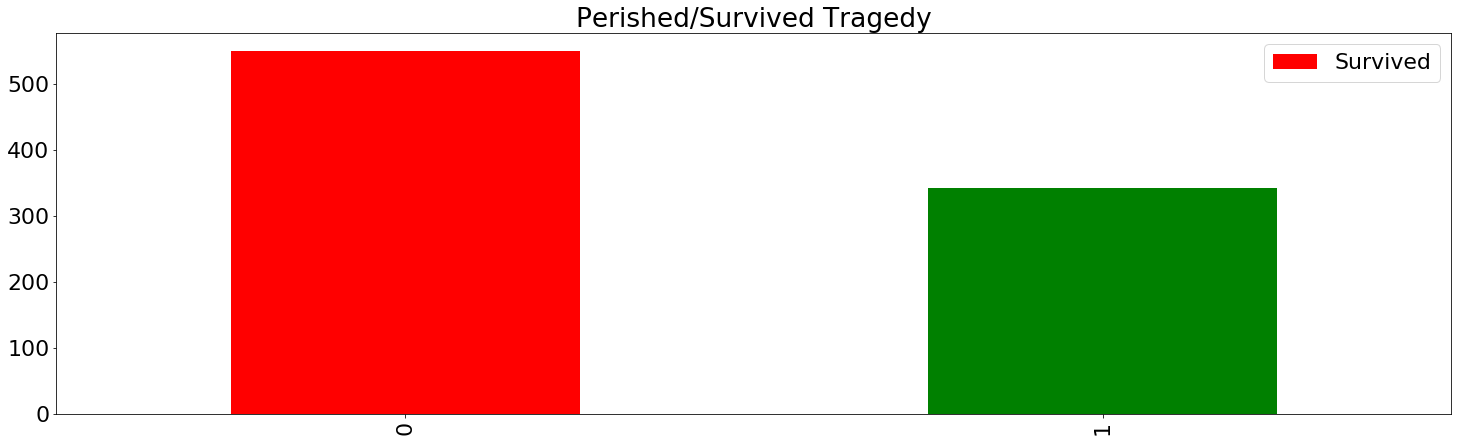

In [22]:
train = pd.read_csv('/home/bthomas/kaggle/titanic/data/train.csv')
test = pd.read_csv('/home/bthomas/kaggle/titanic/data/test.csv')
train['Survived'].value_counts().plot(kind='bar', 
                                       color=['Red', 'Green'], 
                                       title="Perished/Survived Tragedy", 
                                       legend=True, 
                                       figsize=(25,7),
                                       fontsize=22)

The training set ('train') shows a greater tendency toward a survival rate of being false within this set.

For this phase of the workflow, we will combine the data sets so that data transformations can be applied to both sets. A column will be added so that the original data set can be mapped later after featuring engineering.

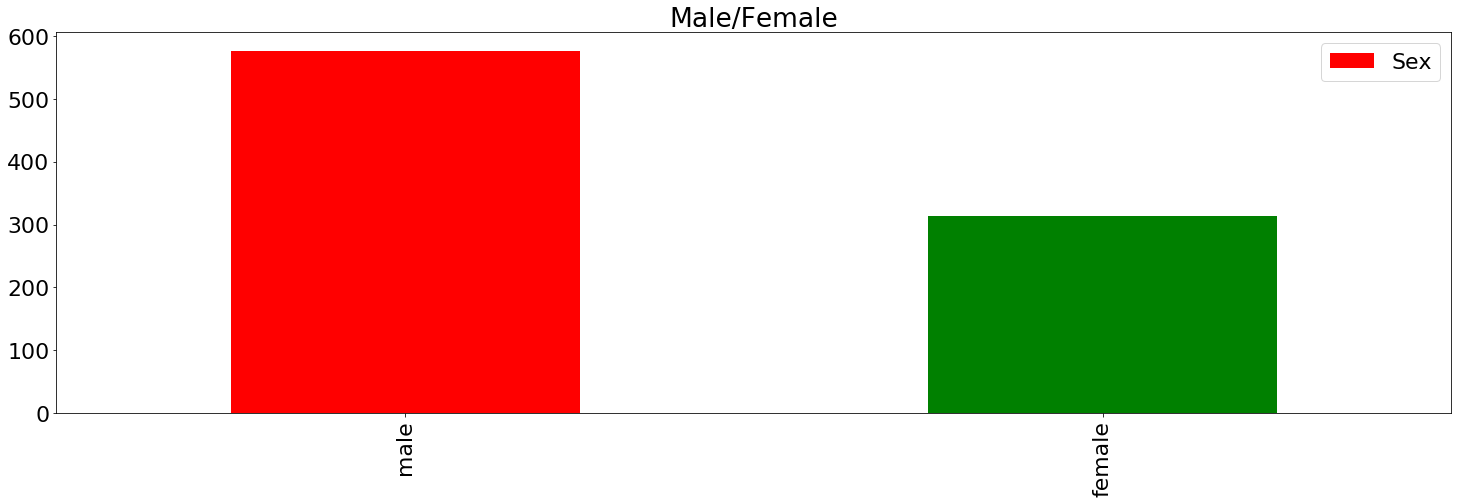

In [23]:
train['Sex'].value_counts().plot(kind='bar', 
                                       color=['Red', 'Green'], 
                                       title="Male/Female", 
                                       legend=True, 
                                       figsize=(25,7),
                                       fontsize=22)

More males are present in the training set which would seem to imply that the greater respresented population would have more survivors, however, the exploratory analysis shows that other factors contributed to survival.

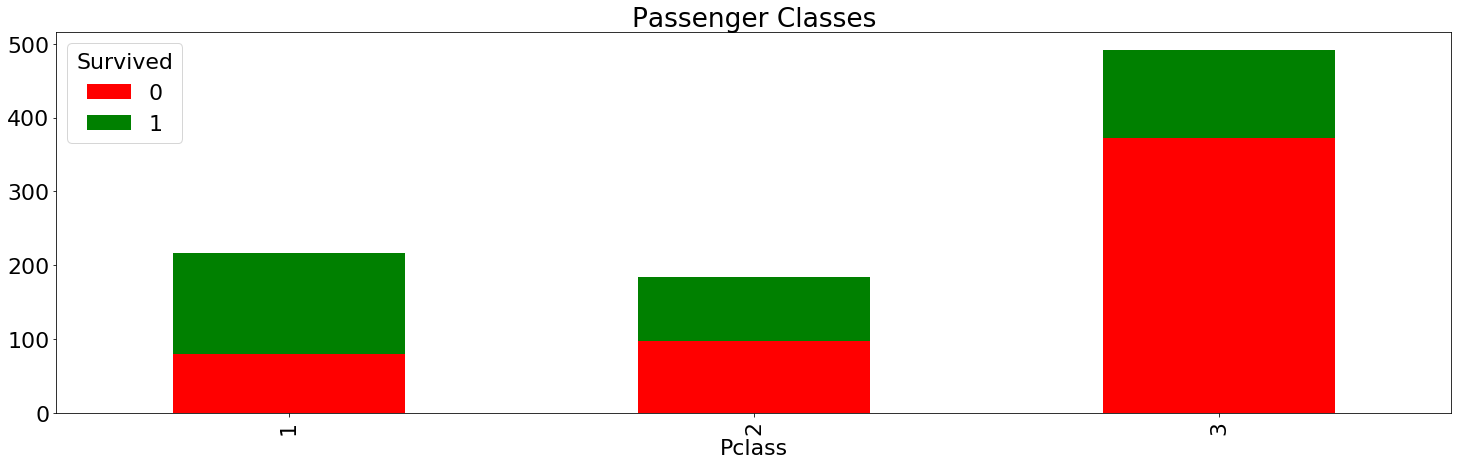

In [24]:
pd.crosstab(train.Pclass, train.Survived).plot(kind='bar', color=['Red', 'Green'], legend=True, title="Passenger Classes", stacked=True, figsize=(25, 7), fontsize=22)

The passenger class (Pclass) indicates that the third passenger class had the greatest lost of life.

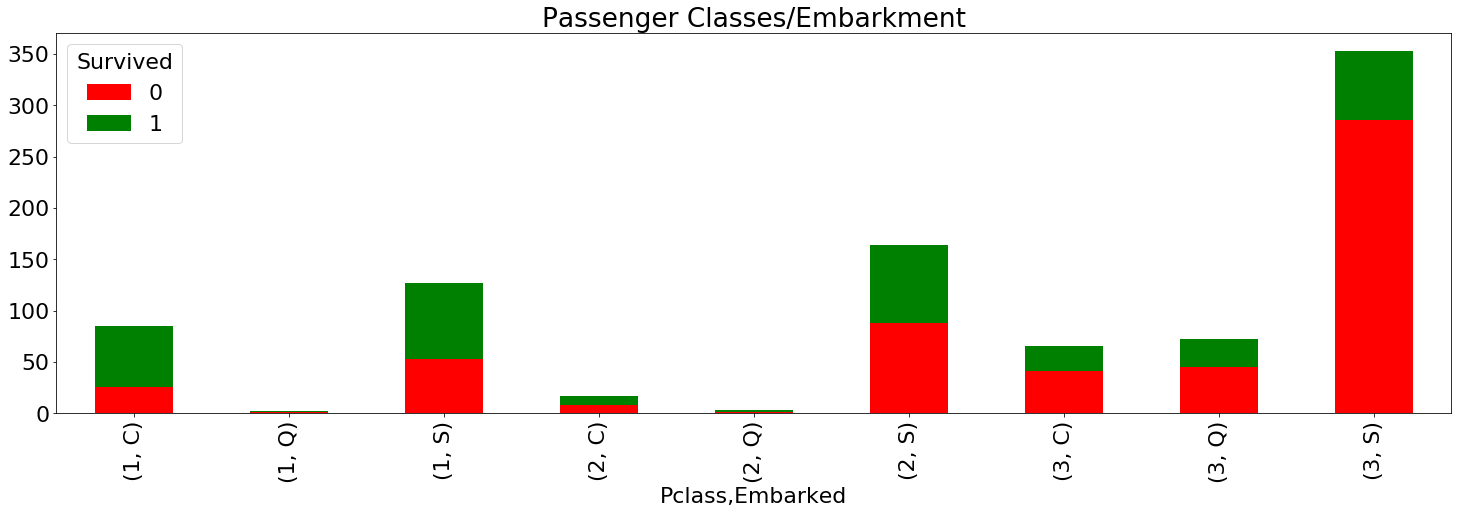

In [25]:
pd.crosstab([train.Pclass, train.Embarked], train.Survived).plot(kind='bar', color=['Red', 'Green'], legend=True, title="Passenger Classes/Embarkment", stacked=True, figsize=(25, 7), fontsize=22)

Third class tickets from embarkment point S had the greatest loss. Second class tickets embarking from S had greater deaths than third class tickets departing from C or Q.

In [26]:
# Combine the datasets so the transformation can be equally applied
train['DataSet'] = 'train'
test['DataSet'] = 'test'
combinedSet = pd.concat([train, test], sort=False)

combinedSet.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataSet
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


A check of the columns, we see that the name column and possibly ticket column have additional information. The name column is well formatted by last name, comma, title, and first name. In the case of married women, the husband's name is used. Ticket columns also may have information that would help expose more information. We will start by using regular expressions to extract the titles.

The regex search below says something like go to the first space, capture the first non white space, the plus means keep extracting, and the \. means stop extracting at the period.

In [27]:
import re
combinedSet['Title'] = ''
for index, t in combinedSet.iterrows():
    title_string = re.search(' (\S+)\.', t.Name).group(1)
    combinedSet.loc[index, 'Title'] = title_string

In [28]:
# Replace the 2 missing Embarked rows with the most frequently port, which is 'S'
combinedSet.Embarked.fillna(value='S', inplace=True)
# Fill in the missing fares with median values
combinedSet.Fare.fillna(value=combinedSet.Fare.median(), inplace=True)
combinedSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
DataSet        1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 193.4+ KB


In [29]:
# compute the total number of passenger using the sibling and parent columns
combinedSet['partySize'] = combinedSet['SibSp'] + combinedSet['Parch']
# compute the total number of passengers traveling on the same ticket
ticket_counts = combinedSet['Ticket'].value_counts()
ticket_counts_df = pd.DataFrame(ticket_counts)
ticket_count_df = ticket_counts_df.reset_index()
ticket_count_df.columns = ['Ticket', 'ticketCount']
combinedSetWithCounts = pd.merge(combinedSet, ticket_counts_df, left_on=combinedSet.Ticket, right_on=ticket_count_df.Ticket, how='outer')
combinedSetWithCounts = combinedSetWithCounts.sort_values(by=['key_0'])


In [30]:
combinedSetWithCounts.columns
combinedSetWithCounts.columns = ['key_0', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket_x', 'Fare', 'Cabin', 'Embarked', 'DataSet',
       'Title', 'familySize', 'partySize']

In [31]:
combinedSetWithCounts = combinedSetWithCounts.drop(['PassengerId', 'Name', 'key_0'], axis=1)

In reviewing the title counts for the combined set, we can see that some titles have opportunities to collapse into a high level lable. For example, Capt, Col, and Military are military titles.


In [32]:
# We are now going to generalize the titles into classes to simplify the number of titles
Title_Dict = {
'Mr' : 'Mr',
'Miss' : 'Miss',
'Mrs' : 'Mrs',
'Master' : 'Child',
'Rev' : 'Professional',
'Dr' : 'Professional',
'Col' : 'Professional', 
'Ms' : 'Miss', 
'Major' : 'Professional',
'Mlle' : 'Miss', 
'Dona' : 'Society',
'Sir' : 'Society',
'Capt' : 'Professional',
'Jonkheer' : 'Society',
'Countess' : 'Society',
'Lady' : 'Society' 	
    
}
pd.DataFrame(list(Title_Dict.items()), columns=['Old', 'New'])['New'].value_counts()
combinedSetWithCounts['Title'] = combinedSetWithCounts['Title'].map(Title_Dict)

In [33]:
# make table of mean ages and then fill in missing ages by title
ages_by_title = combinedSetWithCounts.groupby('Title')['Age'].mean().to_dict()
for index, row in combinedSetWithCounts.iterrows():
    if np.isnan(combinedSetWithCounts.loc[index,'Age']) :
        combinedSetWithCounts.loc[index, 'Age'] = ages_by_title.get(combinedSetWithCounts.loc[index,'Title'])
        

In [34]:
combinedSetWithCounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 419 to 758
Data columns (total 14 columns):
Survived      891 non-null float64
Pclass        1309 non-null int64
Sex           1309 non-null object
Age           1309 non-null float64
SibSp         1309 non-null int64
Parch         1309 non-null int64
Ticket_x      1309 non-null object
Fare          1309 non-null float64
Cabin         295 non-null object
Embarked      1309 non-null object
DataSet       1309 non-null object
Title         1309 non-null object
familySize    1309 non-null int64
partySize     1309 non-null int64
dtypes: float64(3), int64(5), object(6)
memory usage: 193.4+ KB


The map function above allows us to map titles to normalized categories.

Counting the number of passengers reveals that the passenger group is larger than relying on the sibling and parent columns. In looking at the cabin we see a letter which should correspond to the deck. We will next break tickets into letters and numbers.

Pclass, Age, and Fare will be evaluated for missing values. 1,309 rows with Pclass exists-- no missing data. 263 rows with missing ages were found. We created a table of mean ages by titles and then replace the missing age with lookup the mean age.


In [37]:
# Apply preprocessing to scale age and fare values
# Thanks for Ligade for constructing the scaler
std_scale = preprocessing.StandardScaler().fit(combinedSetWithCounts[['Age', 'Fare']])
combinedSetWithCounts[['Age', 'Fare']] = std_scale.transform(combinedSetWithCounts[['Age', 'Fare']])


In [39]:
combinedSetWithCounts['Level'] = combinedSetWithCounts.Cabin.str[:1]
combinedSetWithCounts.Level = combinedSetWithCounts.Level.fillna('U')
combinedSetWithCounts.Level.value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Level, dtype: int64

To evaluate the categorical columns we will convert the columns to dummy variables. fastML.com provides a great tutorial on using dummy variables. [5]

In [40]:
combinedSetWithCounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 419 to 758
Data columns (total 15 columns):
Survived      891 non-null float64
Pclass        1309 non-null int64
Sex           1309 non-null object
Age           1309 non-null float64
SibSp         1309 non-null int64
Parch         1309 non-null int64
Ticket_x      1309 non-null object
Fare          1309 non-null float64
Cabin         295 non-null object
Embarked      1309 non-null object
DataSet       1309 non-null object
Title         1309 non-null object
familySize    1309 non-null int64
partySize     1309 non-null int64
Level         1309 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 203.6+ KB


In [41]:
combinedSetWithCounts = pd.get_dummies(data=combinedSetWithCounts, columns=['Sex','Embarked', 'Title', 'Level'], drop_first=True)

In [22]:
combinedSetWithCounts.head()

,Survived,Pclass,SibSp,Parch,Ticket_x,Cabin,DataSet,familySize,partySize,Age_z,...,Title_Professional,Title_Society,Level_B,Level_C,Level_D,Level_E,Level_F,Level_G,Level_T,Level_U
419,1.0,1,0,0,110152,B77,train,0,3,0.0,...,0,1,1,0,0,0,0,0,0,0
418,1.0,1,0,0,110152,B79,train,0,3,-1.0,...,0,0,1,0,0,0,0,0,0,0
417,1.0,1,0,0,110152,B77,train,0,3,0.0,...,0,0,1,0,0,0,0,0,0,0
429,1.0,1,0,2,110413,E68,train,2,3,-1.0,...,0,0,0,0,0,1,0,0,0,0
427,0.0,1,1,1,110413,E67,train,2,3,2.0,...,0,0,0,0,0,1,0,0,0,0


After making one pass through and doing multiple algorithms I found that I was between .79 and .80 at best. I noticed that Ghouzam [6] approached differently His chart showed a nice breaking of the survival probability thanks to the excellent Seaborn library.

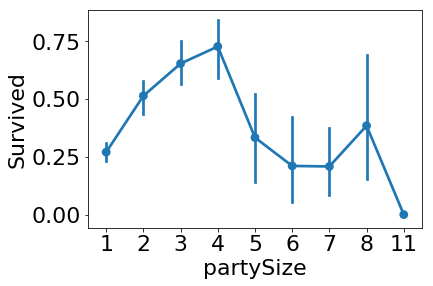

In [24]:
ax = sns.pointplot(x="partySize", y="Survived", data=combinedSetWithCounts)

The chart above shows that the partySize of less than 4 plays a significant role in surving the disaster.

In [25]:
# Create new feature of family size based on chart above
combinedSetWithCounts['Single'] = combinedSetWithCounts['partySize'].map(lambda s: 1 if s == 1 else 0)
combinedSetWithCounts['SmallF'] = combinedSetWithCounts['partySize'].map(lambda s: 1 if  s == 2  else 0)
combinedSetWithCounts['MedF'] = combinedSetWithCounts['partySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
combinedSetWithCounts['LargeF'] = combinedSetWithCounts['partySize'].map(lambda s: 1 if s >= 5 else 0)

partySize is the addition product of Parch and Sibsp. This means that the ticket grouping count, familySize, SibSp,and Parch are duplicate dimensions.

In [26]:
test = combinedSetWithCounts[combinedSetWithCounts.DataSet == 'test']
test = test.drop(['DataSet', 'Survived', 'Ticket_x', 'SibSp', 'Parch', 'familySize', 'partySize'], axis=1)
test.head()

,Pclass,Cabin,Age_z,Fare_z,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,...,Level_D,Level_E,Level_F,Level_G,Level_T,Level_U,Single,SmallF,MedF,LargeF
1267,1,C106,0.0,-0.0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1156,1,D22,1.0,-0.0,1,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
567,1,D37,3.0,1.0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1177,1,NaN,0.0,-0.0,1,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
1223,1,NaN,0.0,-1.0,1,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0


In [27]:
train = combinedSetWithCounts[combinedSetWithCounts.DataSet == 'train']
train = train.drop(['DataSet', 'Cabin', 'Ticket_x', 'SibSp', 'Parch', 'familySize'], axis=1)
train.Survived = train.Survived.astype('int')
train.head()

,Survived,Pclass,partySize,Age_z,Fare_z,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,...,Level_D,Level_E,Level_F,Level_G,Level_T,Level_U,Single,SmallF,MedF,LargeF
419,1,1,3,0.0,1.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
418,1,1,3,-1.0,1.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
417,1,1,3,0.0,1.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
429,1,1,3,-1.0,1.0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
427,0,1,3,2.0,1.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [28]:
print("Train:", train.shape)
print("Test", test.shape)

Train: (891, 25)
Test (418, 24)


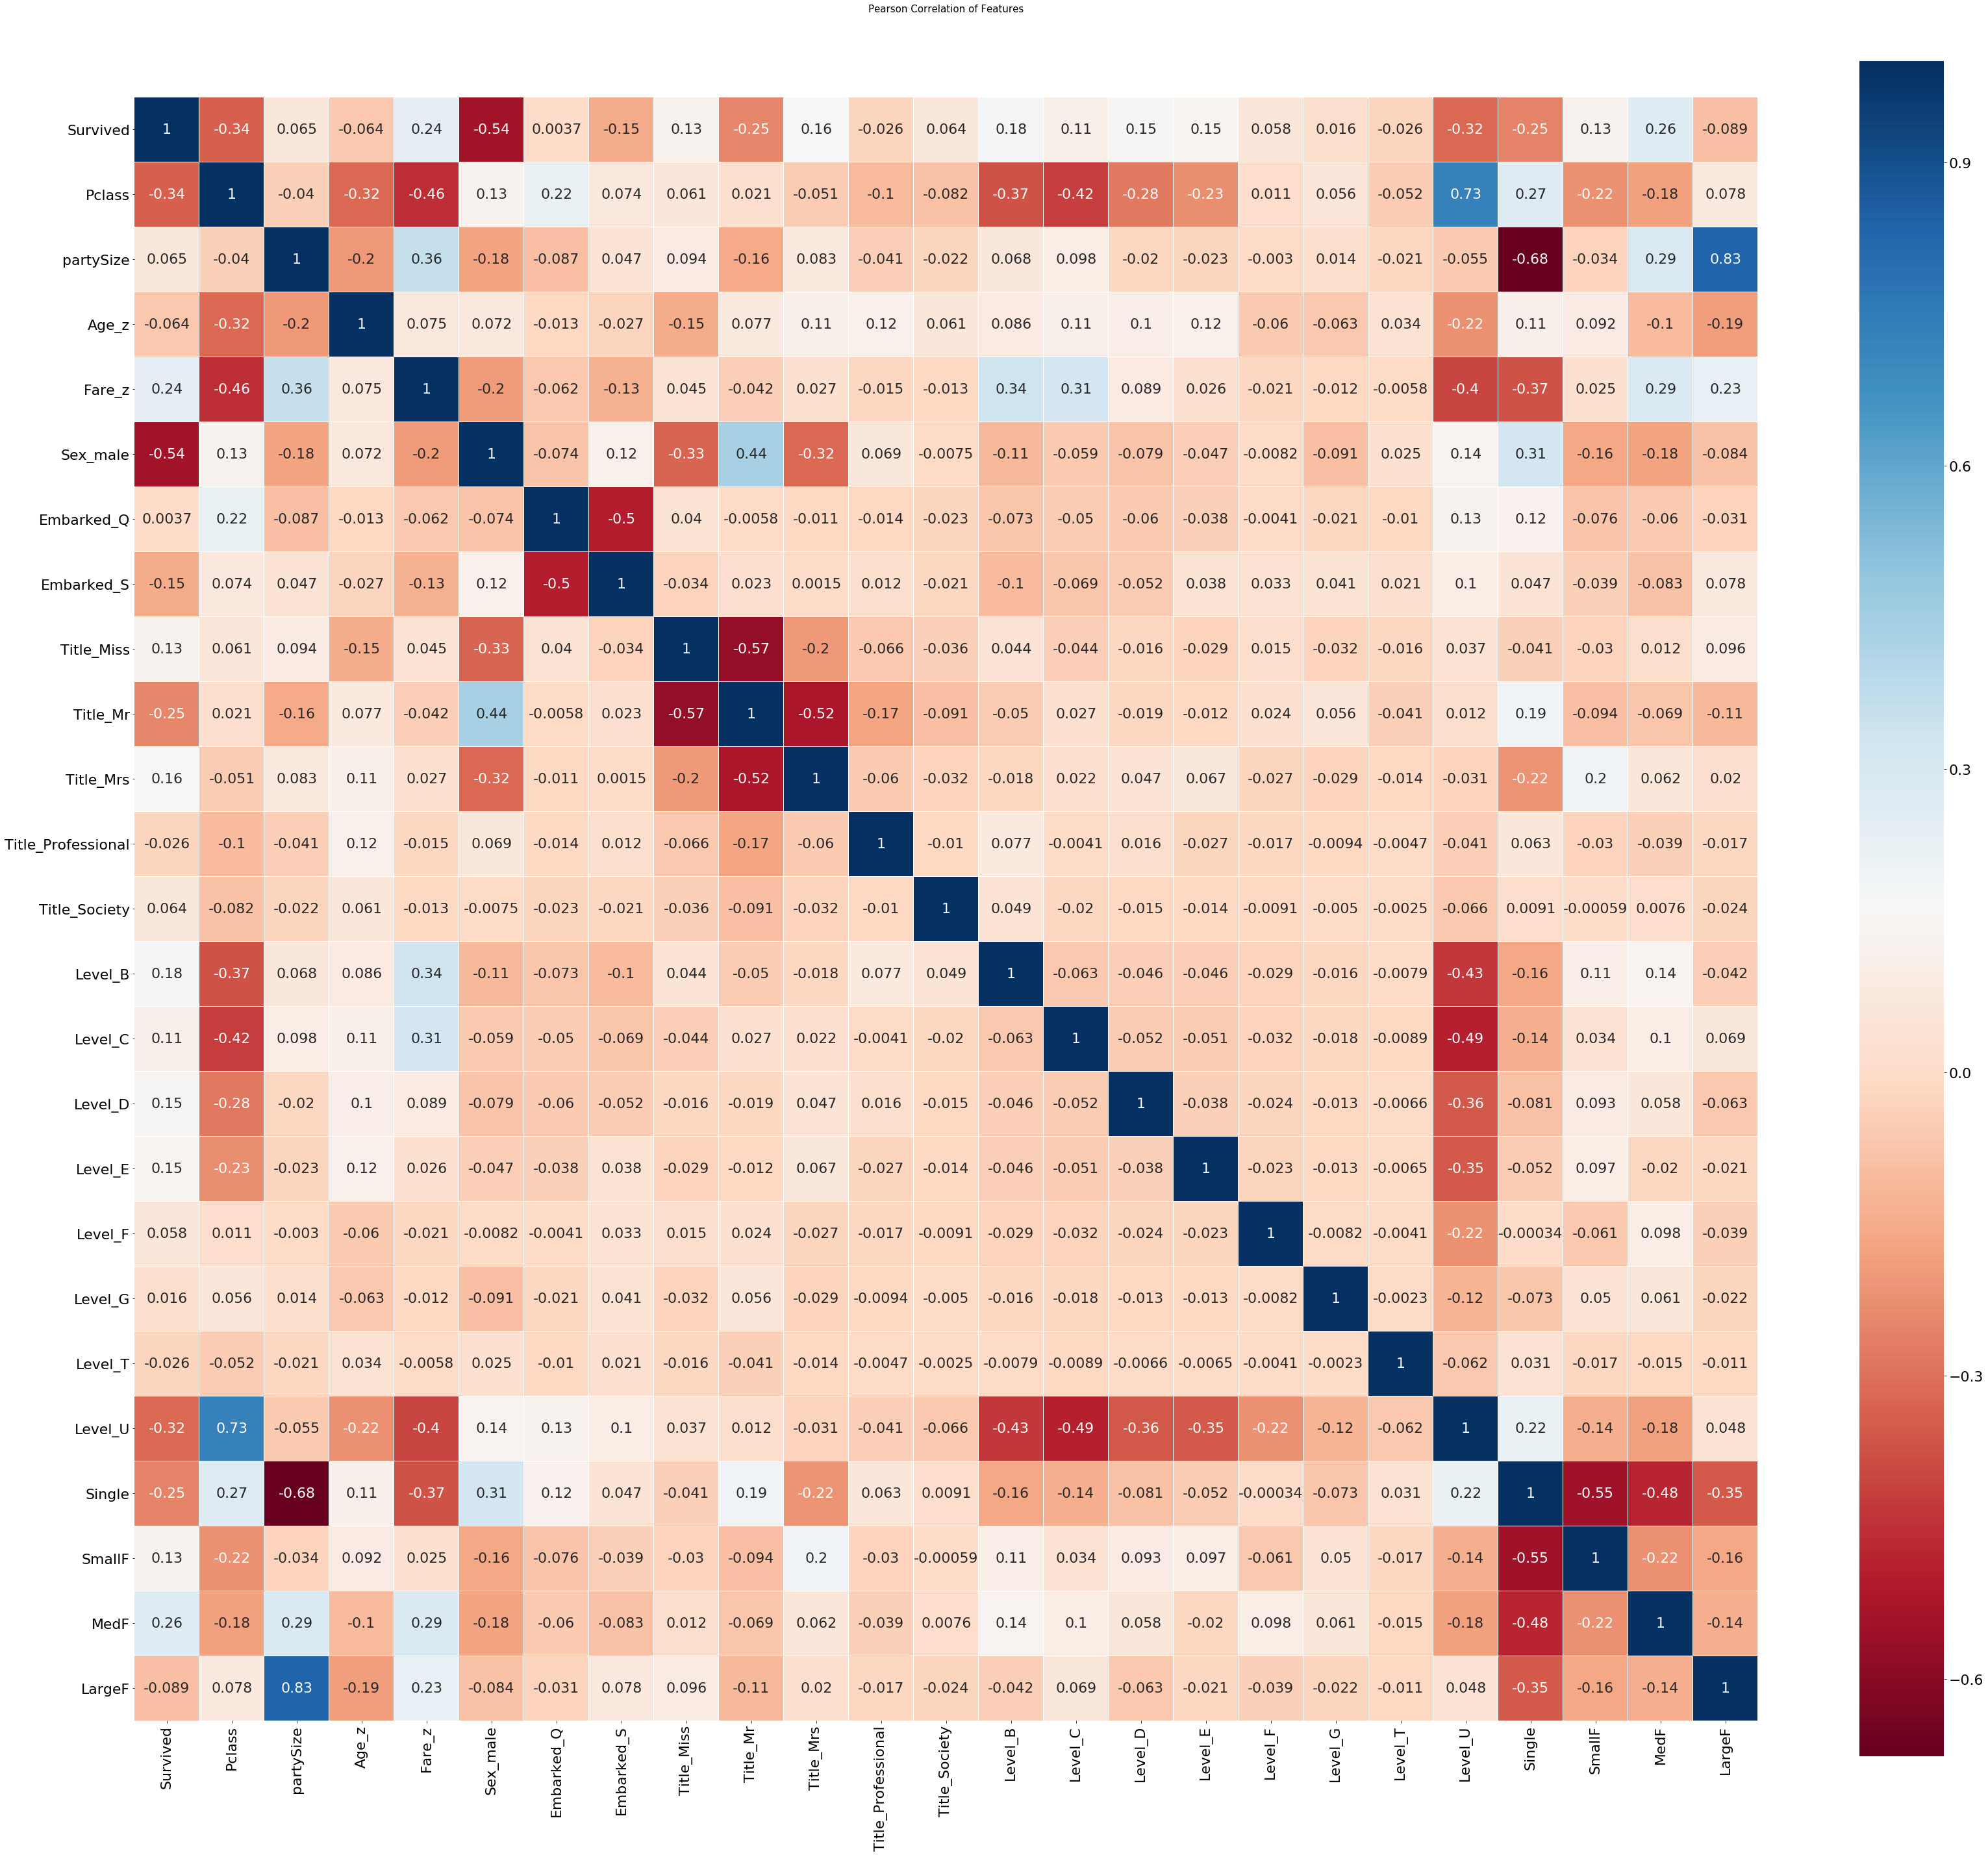

In [29]:
colormap = plt.cm.RdBu
plt.figure(figsize=(56,48))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sc = sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
print("Number of features: %s" % combinedSetWithCounts.shape[1])

Number of features: 31


**XX.X Feature Selection:**
Feature engineering is complete at this point and has developed 35 features. The next step will evaluate features that have the most importance. 

In [31]:
Ypredict = train['Survived']
Xtrain = train.drop("Survived", inplace=True, axis=1)

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, Ypredict)

In [32]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

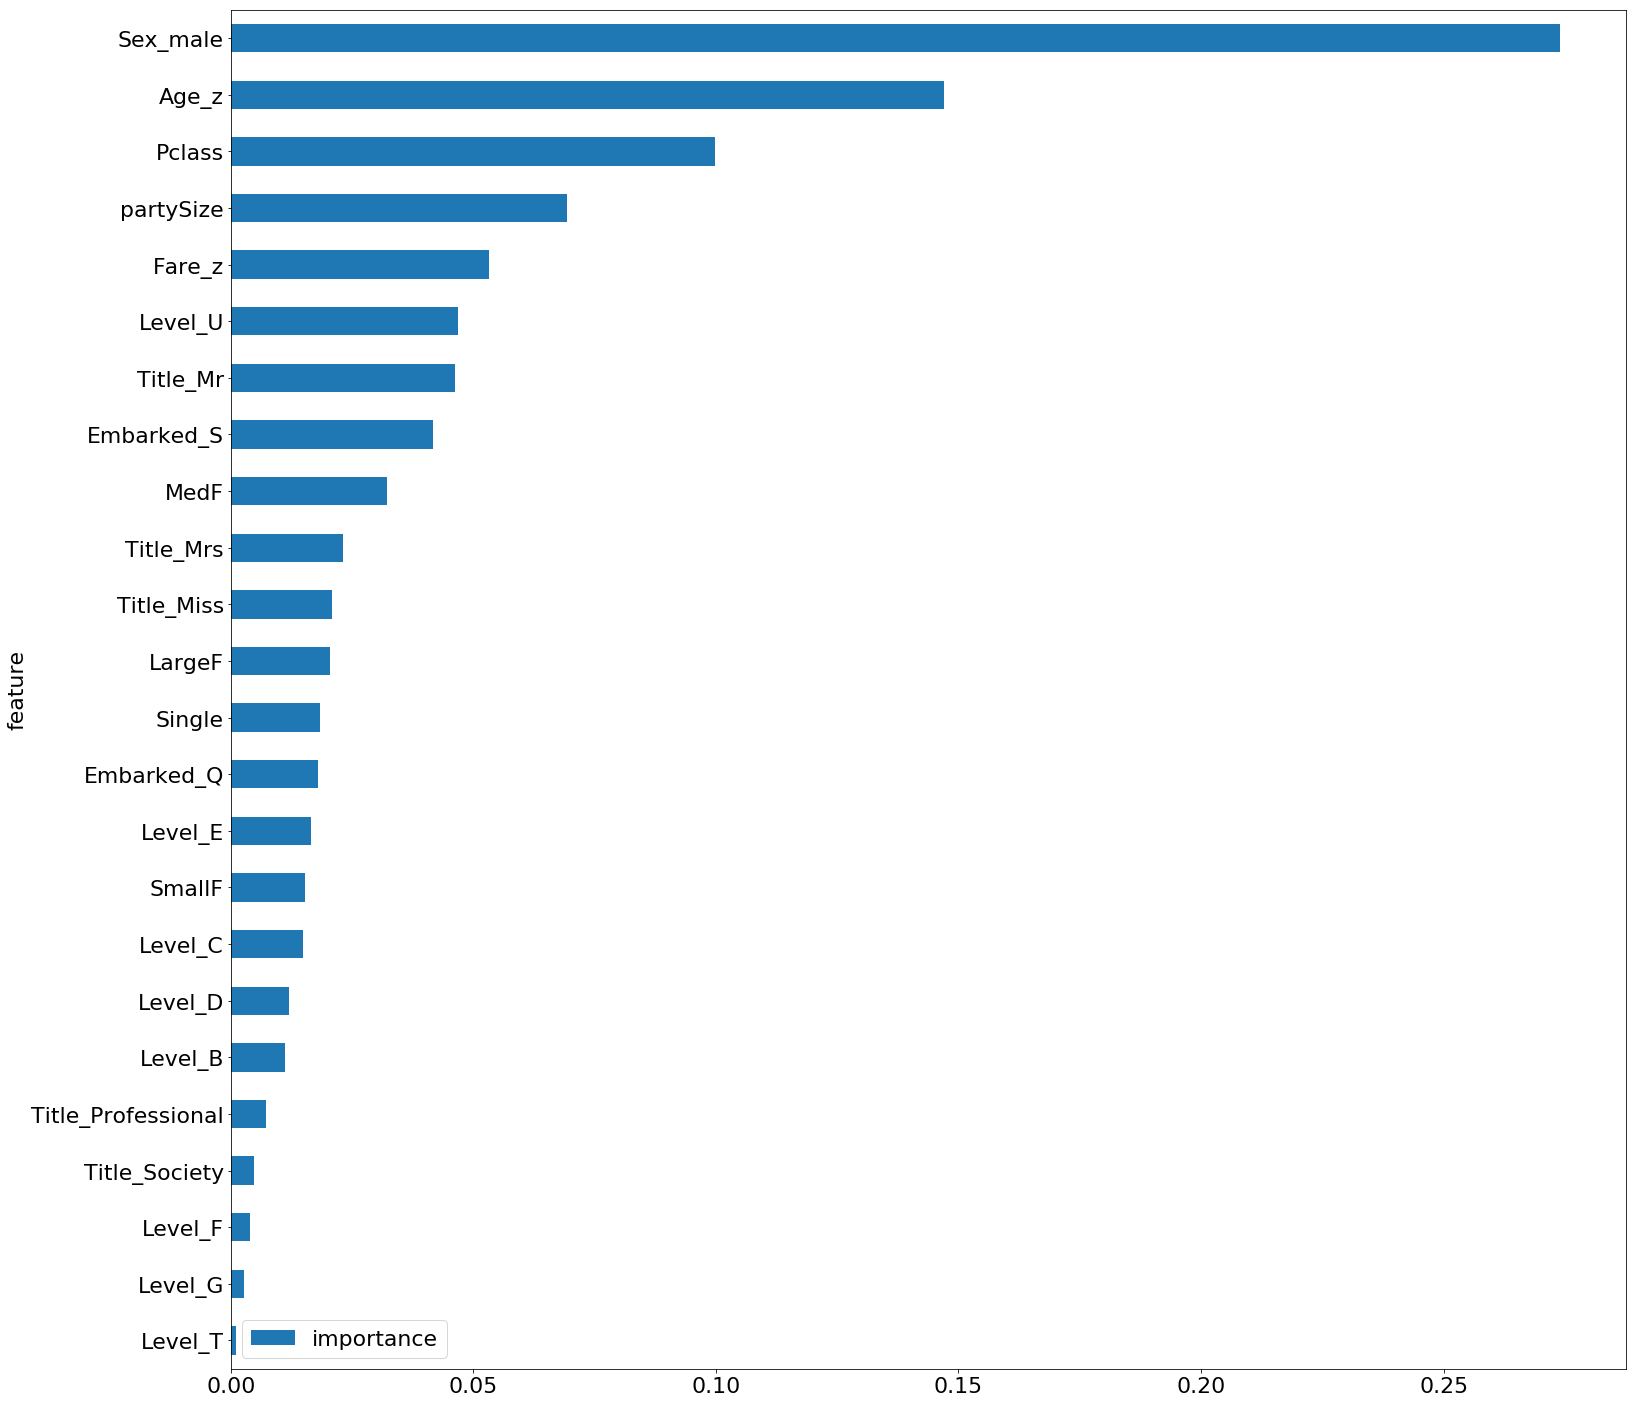

In [33]:
features.plot(kind='barh', figsize=(25, 25))

In [34]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)


(891, 7)


In [35]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 7)


In [36]:
pickle.dump( train_reduced, open( "train_reduced.p", "wb" ) )
pickle.dump( test_reduced, open("test_reduced.p", "wb"))

In [56]:
# *********************************************************************************************

In [37]:
train_reduced = pickle.load(open( "train_reduced.p", "rb" ) )
test_reduced = pickle.load(open("test_reduced.p", "rb"))

SelectFromModel has reduced the dimenions from 25 to 8 which will reduce processsing time, reduces redunacy, and helps prevent overfitting.

In [49]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=50)

In [50]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())



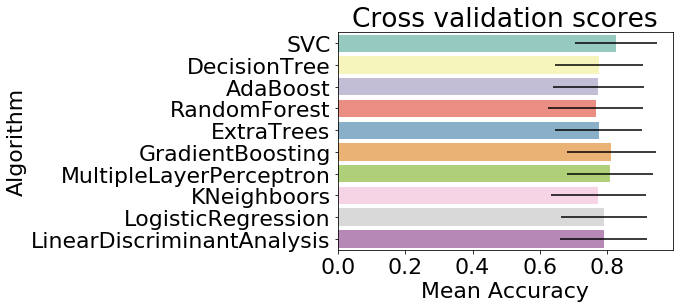

In [51]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, train_reduced, y = Ypredict, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [52]:
pd.DataFrame(cv_res).sort_values(by=['CrossValMeans'])

,CrossValMeans,CrossValerrors,Algorithm
3,0.765057,0.140243,RandomForest
2,0.772827,0.135404,AdaBoost
7,0.773243,0.140213,KNeighboors
4,0.773938,0.129691,ExtraTrees
1,0.774918,0.131006,DecisionTree
8,0.790090,0.127687,LogisticRegression
9,0.790090,0.129129,LinearDiscriminantAnalysis
6,0.808775,0.127013,MultipleLayerPerceptron
5,0.811275,0.132156,GradientBoosting
0,0.824943,0.121159,SVC


**XX.XX Initial Screening:** The initial screening using CrossValMeans indicates that SVC performed the best and had lower CrossValerrors.

In [53]:
#SVC
### SVC classifier
modelResults = []
kernelType = ["linear", "rbf", "sigmoid"]
# precomputed should only be used be used when pass samples 
# poly is special case using degree
for k in kernelType:
    SVMC = SVC(probability=True)
    svc_param_grid = {'kernel': [k], 
                      'gamma': [ 0.001, 0.01, 0.1, 1],
                      'C': [1, 10, 50, 100,200,300, 1000]}
    gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1, iid=True)
    gsSVMC.fit(train_reduced,Ypredict)
    SVMC_best = gsSVMC.best_estimator_
    # Best score
    modelResults.append({"Method" : k, "Score" : gsSVMC.best_score_ })
    print(gsSVMC.best_score_, k)    

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['poly'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000],
                  'degree' : range(1,3,1)}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1, iid=True)
gsSVMC.fit(train_reduced,Ypredict)
SVMC_best = gsSVMC.best_estimator_
# Best score
modelResults.append({"Method" : k, "Score" : gsSVMC.best_score_ })
print(gsSVMC.best_score_, k)
    
pd.DataFrame(modelResults)

Fitting 50 folds for each of 28 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 11.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.7867564534231201 linear
Fitting 50 folds for each of 28 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.8237934904601572 rbf
Fitting 50 folds for each of 28 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:   35.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.7912457912457912 sigmoid
Fitting 50 folds for each of 56 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 617 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 967 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1417 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 1967 tasks      | elapsed: 165.9min
[Parallel(n_jobs=-1)]: Done 2617 tasks      | elapsed: 490.0min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 1249.7min finished


0.8069584736251403 sigmoid


,Method,Score
0,linear,0.786756
1,rbf,0.823793
2,sigmoid,0.791246
3,sigmoid,0.806958


In [57]:
pickle.dump( modelResults, open("parameter_variation.p", "wb"))

In [54]:
# Multilayer Perception
MLP = MLPClassifier()
mlp_param_grid = {'hidden_layer_sizes' : [(8,),(20,),(100,)],
                  'activation' : ['tanh','relu'],
                  'solver' : ['lbfgs','adam'],
                  'max_iter' : [1000]}

gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring='accuracy',n_jobs=-1,verbose=1)
gsMLP.fit(train_reduced,Ypredict)
MLP_best = gsMLP.best_estimator_

gsMLP.best_score_




Fitting 50 folds for each of 12 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.0min finished
/home/bthomas/miniconda3/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bthomas/miniconda3/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8125701459034792

In [55]:
#ExtraTrees Optimization
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [4,6,8],
              "max_features": ['sqrt','log2','auto'],
              "min_samples_split": [1.0, 3, 9],
              "min_samples_leaf": [1, 3, 9],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]
                }


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(train_reduced,Ypredict)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 50 folds for each of 162 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 739 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1539 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2089 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2739 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3489 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4339 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5289 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6339 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 7489 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed:  5.6min finished
/home/bthomas/miniconda3/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change 

0.8125701459034792

In [58]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }


gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_reduced,Ypredict)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 50 folds for each of 72 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 677 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 1677 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done 3077 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3593 out of 3600 | elapsed:  1.6min remaining:    0.2s
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed:  1.6min finished
/home/bthomas/miniconda3/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7991021324354658

In [60]:
#AdaBoost Optimization
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
                 }

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, iid=True, verbose = 1)

gsadaDTC.fit(train_reduced,Ypredict)

ada_best = gsadaDTC.best_estimator_
# Best Score
gsadaDTC.best_score_



Fitting 50 folds for each of 112 candidates, totalling 5600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4048 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5600 out of 5600 | elapsed:    7.2s finished


0.7878787878787878

In [61]:
#Fit Logistic Regression model
LGR = LogisticRegression(solver="lbfgs")
LGR_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
                 }
LGR_DTC = GridSearchCV()

LGR.fit(train_reduced,Ypredict)
LGR.score



TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_grid'

In [115]:
def acc_score(model):
    return np.mean(cross_val_score(model,train_reduced,Ypredict,cv=k_fold,scoring="accuracy"))

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

## Algorithms that were .80 or higher are selected
lda = LinearDiscriminantAnalysis(n_components=4)
lda.fit(train_reduced,Ypredict)
ldaA = lda.transform(train_reduced)
print("Accuracy: " + str(acc_score(lda)))
# confusion_matrix_model(lda)
k_fold = KFold(len(train_reduced),3, shuffle=True)

print('LDA Results: ')
for (trn, tst) in k_fold:
    lda.fit(train_reduced, Ypredict)
    outVal = lda.score(train_reduced, Ypredict)
    #Compute classification error
print('Score: ' + str(outVal))

Accuracy: 0.7957818090515347


TypeError: __init__() got multiple values for argument 'shuffle'

In [50]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1,  iid=True)

gsadaDTC.fit(Xtrain,Ypredict)

ada_best = gsadaDTC.best_estimator_

Fitting 50 folds for each of 112 candidates, totalling 5600 fits


TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [ ]:
gsadaDTC.best_score_

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1,  iid=True)

gsExtC.fit(Xtrain,Ypredict)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1,  iid=True)

gsRFC.fit(Xtrain,Ypredict)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


In [52]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1, iid=True)

gsGBC.fit(Xtrain_reduced,Ypredict)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

NameError: name 'Xtrain_reduced' is not defined

In [73]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1, iid=True)

gsSVMC.fit(Xtrain_reduced,Ypredict)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

NameError: name 'Xtrain_reduced' is not defined

# References
[1] Press, Gil, Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task, Survey Says. Retrieved from https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#4a6b4e846f63 on November 22, 2018.

[2] triangleinequality for matters mathematical retrieved from https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/.

[3] https://www.coursera.org/learn/data-cleaning#%20.

[4] retrieved from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.451.6606&rep=rep1&type=pdf 

[5] retrived from http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/

[6] retrived from https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

[7] retrived from https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline